In preprocessing of transcriptomics, we did not filter for low-mean expression genes. Instead, we assumed that feature selection and model regularization would suffice for appropriately using expression data. 

In [1]:
import os

import pandas as pd
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seed = 42
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'

Load data:

In [5]:
# RNA exprssion mean and variance from Notebook A/01
stats_novst = pd.read_csv(os.path.join(data_path, 'processed', 'expr_rna_stats.csv'), index_col = 0)

# RNA expression matrix from Notebook A/01
expr_rna = pd.read_csv(os.path.join(data_path, 'processed', 'expr.csv'), index_col = 0)
expr_prot = pd.read_csv(os.path.join(data_path, 'processed', 'expr_protein.csv'), index_col = 0)


# model ranks from Notebook C/04
model_ranks = pd.read_csv(os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'), index_col = 0)


# Influence of Low Expression Transcripts

There are now genes expressed in fewer than 50% of samples, so this filter would not have applied anyways:

In [25]:
low_freq_mask = (expr_rna == 0).sum(axis=0) > (0.5 * len(expr_rna))
len(np.where(low_freq_mask)[0])

0

Let's check that low expression genes do not have a strong influence on the consensus joint model fit:



Text(0.5, 0, 'Joint SVR Feature Ranks (1 = "High") \n of bottom 1000 transcripts by mean expression')

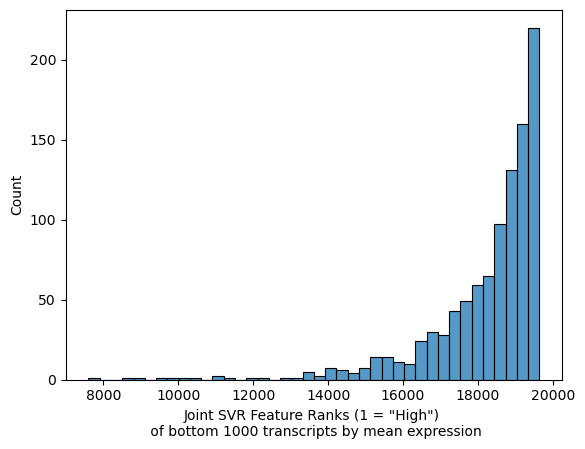

In [73]:
# check whether not filtering out low mean genes effects the final model 
# are low-mean transcript genes highly ranked in the model fit? --> No
ranks = []
counter = 0
for feature in stats_novst.sort_values(by = 'mean', key = abs).index.tolist():
    rank = model_ranks[model_ranks['Feature Name'] == feature].index.tolist()[0]
    ranks.append(rank)
    counter += 1
    if counter == 1000:
        break
g = sns.histplot(ranks)
g.set_xlabel('Joint SVR Feature Ranks (1 = "High") \n of bottom 1000 transcripts by mean expression')

Let's further check that the expression mean does not have a strong influence on model fit:

In [7]:
from scipy import stats
intersect_genes = sorted(set(model_ranks['Feature Name']).intersection(stats_novst.index.tolist()))
sr = stats.spearmanr(stats_novst.loc[intersect_genes, 'mean'].abs(), 
                model_ranks.set_index('Feature Name').loc[intersect_genes, 'SVM coefficient'].abs()).statistic
print('Spearman (Abs Mean TPM, Joint SVR Abs Coefficient): {:3f}'.format(sr))

Spearman (Abs Mean TPM, Joint SVR Abs Coefficient): 0.252374


We see that low expression genes do not have high ranks in the model, and expression mean overall does not have a *strong* association with the model fit, altogether indicating that this filtering step does not strongly influence results. 


# Influence of Coefficient of Variation (CV) as Feature Selection Step

The current pipeline's feature selection step takes top *n* features, where features are ranked by CV.

## Transcriptomics

Next, let's look at how expression effects the coefficient of variance feature selection step:

In [10]:
cv = np.sqrt(stats_novst['variance']) / stats_novst['mean']
a = stats.spearmanr(cv, stats_novst['mean']).statistic

## with low-expression filtering
mask = stats_novst['mean'].abs() < 1
test = stats_novst[~mask].copy()
cv = np.sqrt(test['variance']) / test['mean']
b = stats.spearmanr(cv, test['mean']).statistic

print('Spearman correlation between mean expression and coefficient of variation without and with low-expression filtering is {:.2f} and {:.2f}'.format(a, b))




Spearman correlation between mean expression and coefficient of variation without and with low-expression filtering is -0.94 and -0.87


Both filtered and unfiltered expressoin matrices demonstrate a strong anti-correlation between mean and CV. This further confirms that filtering low-expression genes wouldn't have altered results substantially. *However*,  it also explains why the model may have selected all transcriptomic features -- essentially top-ranked genes by CV are very low mean, so they were included but then not strongly utilized by the model. A residualized variance step may have been better here. 

## Proteomics

In the protein feature selection by CV, the Spearman correlation with mean expression is less pronounced, which is likely why fewer features were selected:

In [41]:
mean_prot_expr = expr_prot.mean(axis = 0)
cv = expr_prot.std(axis = 0) / expr_prot.mean(axis = 0)
a = stats.spearmanr(mean_prot_expr, cv).statistic

print('Protein mean - coefficient of variation Spearman: {:.3f}'.format(a))

Protein mean - coefficient of variation Spearman: 0.218


**However**, we did not account for the fact that both batch-corrected RNA and processed proteomics have negative values. Batch-corrected RNA has very few negative values, so the CV - mean correlation is still strong. Protein has many more, so CV is effected by not accounting for sign changes: 


In [43]:
mean_prot_expr = expr_prot.mean(axis = 0)
cv = expr_prot.std(axis = 0) / expr_prot.mean(axis = 0)
b = stats.spearmanr(mean_prot_expr.abs(), cv.abs()).statistic

print('Protein abs(mean) - abs(coefficient of variation) Spearman when: {:.3f}'.format(b))

Protein abs(mean) - abs(coefficient of variation) Spearman when: -0.963


Thus, coefficient of variation was probably not the best feature selection step, nor not accounting for negative counts in the proteomics when using coefficient of variation. 

What exactly does a signed (rather than absolute value) CV do in proteomics feature ranking?

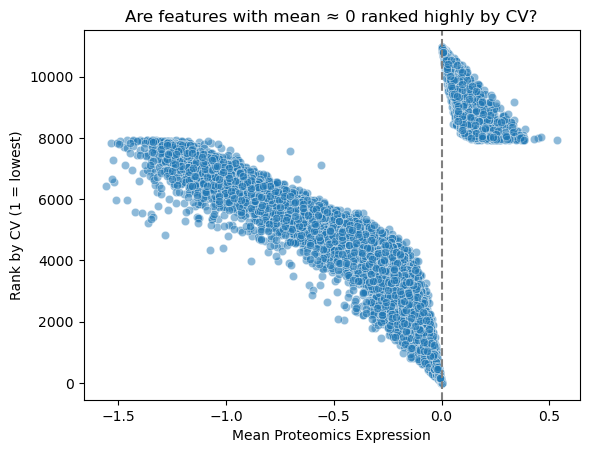

In [71]:
# assuming df is your proteomics matrix (rows = samples, cols = proteins)
mean_vals = expr_prot.mean(axis=0)
std_vals = expr_prot.std(axis=0)
cv_vals = std_vals / mean_vals

cv_rank = cv_vals.rank(ascending=True)  # 1 = lowest CV

cv_df = pd.DataFrame({
    'mean': mean_vals,
    'std': std_vals,
    'cv': cv_vals,
    'cv_rank': cv_rank
})

# plot to see relationship
sns.scatterplot(data=cv_df, x='mean', y='cv_rank', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Mean Proteomics Expression")
plt.ylabel("Rank by CV (1 = lowest)")
plt.title("Are features with mean ≈ 0 ranked highly by CV?")
plt.show()

Implications for CV ranking: Postive values near 0 rank highest, so this is arbitrarily selecting for medium abundance genes. In contrast negative values near 0 rank lowest, so this is arbirtraily excluding these medium abundance genes. Next are increasing in positve values, and then strongly negative values (very low abundance). 

Text(0.5, 1.0, 'Distribution of all Proteomics Expression Values')

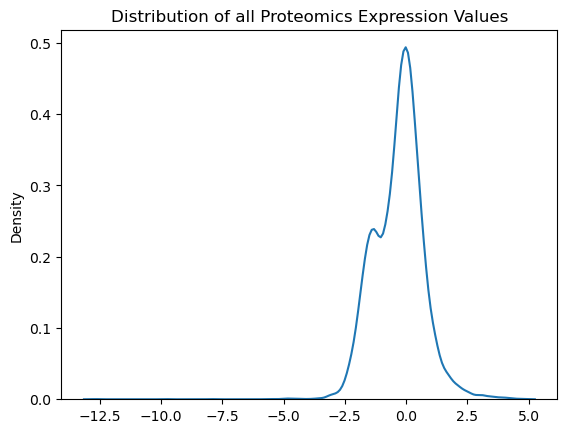

In [72]:
prot_vals = expr_prot.values.flatten()
np.random.seed(seed)
prot_vals = np.random.choice(prot_vals, int(1e4))
g = sns.kdeplot(prot_vals)
g.set_title('Distribution of all Proteomics Expression Values')